# CS 230 Project Code

Russell_v2 contains a hyperparameter search for code written by Delaney on 5/18/21. 

Authors: Delaney Miller and Russell Martin <br>
Class: CS 230: Deep Learning <br>
Date: 16 May 2021 <br>
Description: Predict peak medial knee joint contact force (MCF) from kinematic data (joint angles) during walking using a neural network. This Jupyter Notebook uses open-source code excerpts taken from Boswell et al., 2021 (cited below), who predicted the first peak of knee adduction moment (KAM) from kinematic data in the form of 3D marker coordinates.  This notebook is for testing a variety of neural network architectures as well as combinations of input and output features to evaluate model performance. <br>

Open-source code modified from:

M. A. Boswell et al., “A neural network to predict the knee adduction moment in patients with osteoarthritis using anatomical landmarks obtainable from 2D video analysis,” Osteoarthritis Cartilage, vol. 29, no. 3, pp. 346–356, Mar. 2021, doi: 10.1016/j.joca.2020.12.017.


# Part I: Load and format data

### (1) Load required packages, user inputs

In [13]:
# Taken from from Boswell et al.

# packages 
import scipy.io as sio #
import tensorflow as tf #
import tensorflow_addons as tfa
import numpy as np #
import scipy.signal
import keras
import tensorflow.keras as keras
from keras.models import Sequential
from keras.initializers import glorot_normal
from keras.layers import Dense, Dropout
import tensorflow.python.keras.backend as K
from keras.losses import mean_squared_error
import matplotlib.pyplot as plt #
%matplotlib inline
import csv
import scipy.stats
import os
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold   #for k fold cross validation
import time

# Flag if 3D, frontal, or sagittal
modeltype = '3D' # Options are '3D', 'frontal', or 'sagittal'
outputType = 'both' # Options are 'early', 'late', 'both', 'three', 'max', and 'all' for peak MCF
    
# Configure to use CPU or GPU (we are using CPU)
config = tf.compat.v1.ConfigProto(device_count = {'CPU' : 1, 'GPU' : 0})
session = tf.compat.v1.Session(config=config)
K.set_session(session)

### (2) Define functions for later in script

In [2]:
# Taken from Boswell et al., modified to say "MCF"

def r2_numpy(data,labels,model):
    y_pred2 = model.predict(data)
    mse = np.mean(np.square(y_pred2-labels))
    r2 = np.square(np.corrcoef(labels.T,y_pred2.T)[0,1])
    mae = np.mean(np.abs(y_pred2-labels))
    return r2,mse,mae

def PredictMCF(model,inputData):
    predictedMCF = model.predict(inputData[range(inputData.shape[0]),:])
    return predictedMCF

def PlotMCFpredictions(trueMCF,predictedMCF):
    # Plot predicted and true peaks vs. step
    plt.figure()
    truePlot = plt.plot(trueMCF)
    predPlot = plt.plot(predictedMCF)
    plt.ylabel('MCF Peak Comparison')
    plt.xlabel('Step')
    plt.legend(('True','Predicted'),loc=4);

    # Plot predicted vs. true peaks
    plt.figure()
    ax = plt.plot(trueMCF,predictedMCF,'.',color=(45/255, 107/255, 179/255),alpha=0.05)
    plt.axis('equal')
    plt.ylabel('Predicted MCF')
    plt.xlabel('True MCF')
    plt.ylim(1,4)
    plt.xlim(1,4)
    plt.plot([-1,4],[-1,4],'k')
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
def PlotTrainingCurves(trainResults,devResults,epochCount):
    # Plot training curves
    lossPlt = plt.plot(np.arange(1,epochCount+1),train_loss[range(epochCount)])
    DevlossPlt = plt.plot(np.arange(1,epochCount+1),dev_loss[range(epochCount)])

    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch Number');
    plt.legend(('Training','Dev'))

    plt.figure(2)
    r2Plt = plt.plot(np.arange(1,epochCount+1),train_r2[range(epochCount)])
    devr2Plt = plt.plot(np.arange(1,epochCount+1),dev_r2[range(epochCount)])
    plt.ylim([.2, 1])
    plt.ylabel('r^2')
    plt.xlabel('Epoch Number');
    plt.legend(('Training','Dev'))
    
if modeltype not in ['3D', 'frontal', 'sagittal']:
    raise ValueError("Error: Options are '3D' 'frontal' or 'sagittal'.")

### (3) Load input data

In [3]:
# Load input data
inputData = sio.loadmat("Data\inputData.mat")

# Load input data (X)
ik_input = inputData["ik"] # inverse kinematics (101, 31, 7779)
time_input = inputData["time"] # time (101, 1, 7779)
leg = inputData["leg"].T  # stance leg (per step) (7779,1)
subject = inputData["subject"].T  # subject number (per step) (7779,1)

# Load output data (Y)
MCF = inputData["MCF"] # MCF over time (101, 7779)
peakMCF_early = inputData["peakMCF_early"].T # early stance peak (SORT OF NOT WORKING RN)
peakMCF_late = inputData["peakMCF_late"].T # late stance peak (SORT OF NOT WORKING RN)
minMCF = inputData["minMCF"].T # mid stance valley
peakMCF = inputData["peakMCF"]

# Print output dimensions
print("Inverse kinematics: " + str(ik_input.shape))
print("Time: " + str(time_input.shape))
print("Stance leg: " + str(leg.shape))
print("Subject number: " + str(subject.shape))
print("Medial contact force: " + str(MCF.shape))
print("Peak MCF: " + str(peakMCF.shape))
print("Early-stance MCF peak: " + str(peakMCF_early.shape))
print("Late-stance MCF peak: " + str(peakMCF_late.shape))
print("Mid-stance MCF valley: " + str(minMCF.shape))

Inverse kinematics: (101, 31, 7779)
Time: (101, 1, 7779)
Stance leg: (7779, 1)
Subject number: (7779, 1)
Medial contact force: (101, 7779)
Peak MCF: (1, 7779)
Early-stance MCF peak: (7779, 1)
Late-stance MCF peak: (7779, 1)
Mid-stance MCF valley: (7779, 1)


### (4) Format input data

In [4]:
# Leg dimensions (nSamples, 101, 1)
legBin = np.expand_dims(np.tile(leg,(1,101)),axis=2)
print("Leg: " + str(legBin.shape))

# Adjust joint angles to correct dimensions (nSamples, nTimesteps, nFeatures)
angles = np.transpose(ik_input, axes=[2, 0, 1])
print("Joint angles: " + str(angles.shape))

# Time dimensions (nSamples, 1, 1) - DON'T END UP USING
time = np.expand_dims(np.transpose(time_input), axis = 2)
print("Time: " + str(time.shape))

# Concatenate legBin with angles
inputMat = np.concatenate((angles, legBin), axis = 2)

# Resample inputMat (nTimesteps = 16, down from 101)
inputMat = scipy.signal.resample(inputMat, 16, axis = 1)

# Use positions from first half of stance
#inputMat = inputMat[:,0:50,:]
print("Input shape: " + str(inputMat.shape))

Leg: (7779, 101, 1)
Joint angles: (7779, 101, 31)
Time: (7779, 1, 1, 101)
Input shape: (7779, 16, 32)


### (5) Format output data

Output shape is: (7779, 2, 1)


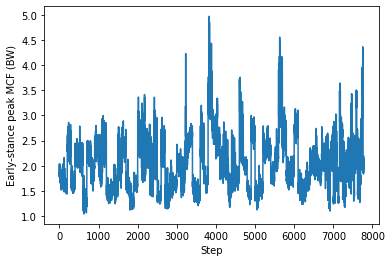

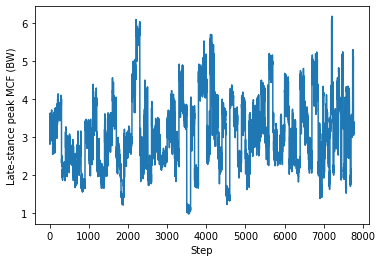

In [5]:
if outputType == 'all':
    output = np.expand_dims(MCF.T, axis = 2)
    output = scipy.signal.resample(output, 32, axis = 1)
    print("Output shape is: " + str(output.shape))
    
elif outputType == 'three':
    output = np.concatenate([peakMCF_early, minMCF], axis = 1)
    output = np.expand_dims(np.concatenate([output, peakMCF_late], axis = 1),axis = 2)
    
    # plot both peaks and valley
    plt.figure()
    plt.plot(output[:,0,0]);
    plt.ylabel("Early-stance peak MCF (BW)");
    plt.xlabel("Step");
    plt.figure()
    plt.plot(output[:,1,0]);
    plt.ylabel("Mid-stance minimum MCF (BW)");
    plt.xlabel("Step");
    plt.figure()
    plt.plot(output[:,2,0]);
    plt.ylabel("Late-stance peak MCF (BW)");
    plt.xlabel("Step");

elif outputType == 'both':
    # next step: multiple outputs (e.g. early and late-stance peaks in MCF)
    output = np.expand_dims(np.concatenate([peakMCF_early, peakMCF_late], axis = 1),axis = 2)
    print("Output shape is: " + str(output.shape))

    # plot both peaks
    plt.figure(1)
    plt.plot(output[:,0,0]);
    plt.ylabel("Early-stance peak MCF (BW)");
    plt.xlabel("Step");
    plt.figure(2)
    plt.plot(output[:,1,0]);
    plt.ylabel("Late-stance peak MCF (BW)");
    plt.xlabel("Step");

else:
    if outputType == 'early':
        # Reshape the output (nSamples, 1, 1)
        output = np.expand_dims(peakMCF_early,axis=2)
    
    elif outputType == 'late':
        output = np.expand_dims(peakMCF_early,axis=2)
        
    elif outputType == 'max':
        output = np.expand_dims(peakMCF,axis=2)

    print("Output shape is " + str(output.shape))
    # Plot output data
    plt.plot(output[:,0,0]);
    plt.ylabel("Peak MCF (BW)");
    plt.xlabel("Step");

### (6) Divide into train, development, and test sets

In [6]:
# Set the seed so it is reproducible
np.random.seed(1)
nSubjects = len(np.unique(subject)) # 68 subjects
subject_shuffle = np.unique(subject)
np.random.shuffle(subject_shuffle)

# 80-10-10 split (54-7-7 subjects)
train, dev, test = np.split(subject_shuffle, [int(0.8*len(subject_shuffle)), int(0.9*len(subject_shuffle))])
print("Train: " + str(len(train)) + " subjects")
print("Dev: " + str(len(dev)) + " subjects")
print("Test: " + str(len(test)) + " subjects")

# Find step indicies for each subject in each set (taken from Boswell et al., 2021)
trainInds = np.array(0)
for i in train:
    trainInds = np.append(trainInds,np.argwhere(subject==i)[:,0])
trainInds = trainInds[1:]
    
devInds = np.array(0)
for i in dev:
    devInds = np.append(devInds,np.argwhere(subject==i)[:,0])
devInds = devInds[1:]

testInds = np.array(0)
for i in test:
    testInds = np.append(testInds,np.argwhere(subject==i)[:,0])
testInds = testInds[1:]

# Build training, development, and test inputs and labels (taken from Boswell et al., 2021)
trainInput_full = inputMat[trainInds,:,:]
trainInput_full = trainInput_full.reshape((trainInput_full.shape[0],-1)) # flatten
trainLabels = output[trainInds,:,0]

devInput_full = inputMat[devInds,:,:]
devInput_full = devInput_full.reshape((devInput_full.shape[0],-1)) # flatten
devLabels = output[devInds,:,0]

testInput_full = inputMat[testInds,:,:]
testInput_full = testInput_full.reshape((testInput_full.shape[0],-1))
testLabels = output[testInds,:,0]

Train: 54 subjects
Dev: 7 subjects
Test: 7 subjects


### (7) Remove redundant leg inputs

In [7]:
# Extract indices of leg (every 32nd index, leave first one)
inputIdx = np.delete(np.arange(0,trainInput_full.shape[1]), np.arange(63, trainInput_full.shape[1], 32))

# Could also do some sort of input feature selection here if we wanted to!

# Remove additional leg input features
trainInput = trainInput_full[:,inputIdx]
devInput = devInput_full[:,inputIdx]
testInput = testInput_full[:,inputIdx]

print("Train input: " + str(trainInput.shape))
print("Dev input: " + str(devInput.shape))
print("Test input: " + str(testInput.shape))

Train input: (6159, 497)
Dev input: (820, 497)
Test input: (800, 497)


# Part II: Train feed-forward neural network

In the current version, we predict the early and late stance peaks of MCF, along with the mid-stance valley.

### (8) Construct model function

In [8]:
# Modified from Boswell et al., 2021

def construct_model(nHiddenUnits, nHiddenLayers, input_dim, output_dim, loss):
    np.random.seed(2)
    tf.compat.v1.set_random_seed(2)

    model = Sequential()
    kernel_regularizer= tf.keras.regularizers.L2(0.2) # added (changed from 0.01 to 0.1)
    bias_regularizer= tf.keras.regularizers.l2(0.2) # added
    # kernel_regularizer= tf.keras.regularizers L1L2(l1 = 1., l2 = 1.) # added (changed from 0.01 to 0.1)
    
    model.add(BatchNormalization(momentum=0.0))
    model.add(Dense(800,input_shape = (input_dim,), kernel_initializer=glorot_normal(seed=None) , activation='relu'), )
    
    for i in range(nHiddenLayers-1):
        model.add(Dropout(0.01))
        model.add(Dense(nHiddenUnits, kernel_initializer=glorot_normal(seed=None) , activation='relu', kernel_regularizer = kernel_regularizer, bias_regularizer = bias_regularizer))
    
    model.add(Dropout(0.01))
    model.add(Dense(output_dim,kernel_initializer=glorot_normal(seed=None),activation='linear'))
    # rmse = tf.keras.metrics.RootMeanSquaredError()
    model.compile(loss=loss,optimizer='adam', metrics=['mse'])
    return model

### (9.0) Train a model (Delaney's Code)   

In [ ]:
# create model
myModel = construct_model(nHiddenUnits = 100, nHiddenLayers = 1, input_dim = trainInput.shape[1], 
                          output_dim = trainLabels.shape[1], loss = 'mse')
#myModel.summary()

# early stopping when there is no improvement in 10 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = "min", patience=20, restore_best_weights = True)

# fit model on training data
history = myModel.fit(trainInput, trainLabels, validation_data=(devInput, devLabels), epochs = 100, 
                      callbacks = [callback], verbose = 2)
# _, train_mse = myModel.evaluate(trainInput, trainLabels, verbose=0)

# plot loss during training
plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

# plot mse during training
plt.figure()
plt.title('Mean Squared Error')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='dev')
plt.legend()
plt.show()

# predict on dev set
# yhat = myModel.predict(devInput)

### (9.1) Train a model k-fold cross validation

In [ ]:
# Written by Delaney 5/18/21, additions by RM 5/20/21

# Holdout cross-val code adapted from https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/#code-example-k-fold-cross-validation-with-tensorflow-and-keras

#define number of folds for k-fold cross validation
num_folds = 8

# Merge inputs and targets
inputs = np.concatenate((trainInput, devInput), axis=0)
targets = np.concatenate((trainLabels, devLabels), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    # create model
    myModel = construct_model(nHiddenUnits = 100, nHiddenLayers = 1, input_dim = trainInput.shape[1], 
                            output_dim = trainLabels.shape[1], loss = 'mse')
    if fold_no ==1: myModel.summary()

    # early stopping when there is no improvement in 10 epochs
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = "min", patience=20, restore_best_weights = True)

    # fit model on training data
    history = myModel.fit(trainInput, trainLabels, validation_data=(devInput, devLabels), epochs = 100, 
                        callbacks = [callback], verbose = 0)
    # _, train_mse = myModel.evaluate(trainInput, trainLabels, verbose=0)

    scores = myModel.evaluate(inputs[test], targets[test], verbose=0)

    print(f'Score for fold {fold_no}: {myModel.metrics_names[0]} of {scores[0]}; {myModel.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1


# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# plot loss during training
plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

# plot mse during training
plt.figure()
plt.title('Mean Squared Error')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='dev')
plt.legend()
plt.show()

# predict on dev set
# yhat = myModel.predict(devInput)

### (9.2) Hyperparameter optimization

In [8]:
def construct_model_forSearch(hParams, input_dim, output_dim, loss):

    #unpack hParams
    kernelRegularizerVal = hParams[0]
    biasRegularizerVal = hParams[1]
    nHiddenUnits = int(hParams[2])
    nHiddenLayers = int(hParams[3])
    useBatchNorm = hParams[4]
    batchNormMomentum = hParams[5]
    dropoutRate_inputLayer = hParams[6]
    dropoutRate_hiddenLayer = hParams[7]
    Optimizer = ('Adam', 'RMSprop')[int(hParams[8])]
    #hParams[9] is batch size
    nInputUnits = int(hParams[10])

    #np.random.seed(2)
    tf.compat.v1.set_random_seed(2)

    model = Sequential()
        
    if useBatchNorm: 
        model.add(BatchNormalization(momentum=batchNormMomentum))
    
    #input layer
    model.add(Dense(nInputUnits,input_shape = (input_dim,), kernel_initializer=glorot_normal(seed=None) , activation='relu'), )
    model.add(Dropout(dropoutRate_inputLayer))
    
    #hidden layers
    kernel_regularizer= tf.keras.regularizers.l2(kernelRegularizerVal) 
    bias_regularizer= tf.keras.regularizers.l2(biasRegularizerVal) 

    for i in range(nHiddenLayers-1):
        model.add(Dense(nHiddenUnits, kernel_initializer=glorot_normal(seed=None) , activation='relu', kernel_regularizer = kernel_regularizer, bias_regularizer = bias_regularizer))
        model.add(Dropout(dropoutRate_hiddenLayer))
    
    #output layer
    model.add(Dense(output_dim,kernel_initializer=glorot_normal(seed=None),activation='linear'))
    # rmse = tf.keras.metrics.RootMeanSquaredError()
    model.compile(loss=loss,optimizer=Optimizer, metrics=['mse'])
    return model  



In [11]:
#define random parameters to test
numSearches = 1000   #number of neural nets to create with randomized hyperparameters
optimizers = ('Adam','RMSprop')
hParamMatrix = np.empty((0,11))

for i in range(numSearches):
    # kernelRegularizer = 10**np.random.uniform(-9,-1)                #L2 kernel regularizer between 0-0.1, log scale
    # biasRegularizer = 10**np.random.uniform(-9,-1)                  #L2 bias reg between 0-0.1, log scale
    # nHiddenUnits = round(10**np.random.uniform(.3,3))               #nHiddenUnits between 2-1000, log scale
    # nHiddenLayers = round(np.random.uniform(1,20))                  #nHiddenLayers between 1-20
    # useBatchNorm = round(np.random.uniform())                       #useBatchNorm true or false
    # batchNormMomentum = 1-10**np.random.uniform(-2,-1)        #batch norm momentum between 0.9-0.99
    # dropoutRate_inputLayer = np.random.uniform(0.05,0.95)            #input layer dropout rate between 0.05-0.95
    # dropoutRate_hiddenLayer = np.random.uniform(0.05,0.95)           #hidden layer dropout rate between 0.05-0.95
    # Optimizer = np.random.randint(0,1)                              #This was supposed to do 'optimizer Adam (0) or RMSprop (1)'. Instead it always chose Adam because I should have used (0,2). Keeping this line for bookkeeping. 
    
    # batchSize = 2**np.random.randint(4,8)                               #minibatch size between 16-128 by 2^n
    
    #search part 2 - using mean +- 2*SD range from best 23 scoring architectures from search above
    # kernelRegularizer = 10**np.random.uniform(-9,-2.8)                #L2 kernel regularizer between 0-0.0014, log scale
    # biasRegularizer = 10**np.random.uniform(-9,-1.4)                  #L2 bias reg between 0-0.038, log scale
    # nHiddenUnits = round(10**np.random.uniform(1.5,2.8))               #nHiddenUnits between 32-625, log scale
    # nHiddenLayers = round(np.random.uniform(2,10))                  #nHiddenLayers between 2-10
    # useBatchNorm = round(np.random.uniform())                       #useBatchNorm true or false
    # batchNormMomentum = 1-10**np.random.uniform(-3,-1.046)        #batch norm momentum between 0.91-0.999
    # dropoutRate_inputLayer = np.random.uniform(0.05,0.88)            #input layer dropout rate between 0.05-0.88
    # dropoutRate_hiddenLayer = np.random.uniform(0.05,0.59)           #hidden layer dropout rate between 0.05-0.59
    # Optimizer = np.random.randint(0,1)                              #This was supposed to do 'optimizer Adam (0) or RMSprop (1)'. Instead it always chose Adam because I should have used (0,2). Keeping this line for bookkeeping. 
    
    # batchSize = 2**np.random.randint(4,8)                               #minibatch size between 16-128 by 2^n

    #search part 2 - using mean +- 2*SD range from best 23 scoring architectures from search above
    kernelRegularizer = 10**np.random.uniform(-9,-2.8)                #L2 kernel regularizer between 0-0.0014, log scale
    biasRegularizer = 10**np.random.uniform(-9,-1.4)                  #L2 bias reg between 0-0.038, log scale
    nHiddenUnits = round(10**np.random.uniform(1.5,2.8))               #nHiddenUnits between 32-625, log scale
    nHiddenLayers = round(np.random.uniform(2,10))                  #nHiddenLayers between 2-10
    useBatchNorm = round(np.random.uniform())                       #useBatchNorm true or false
    batchNormMomentum = 1-10**np.random.uniform(-3,-1.046)        #batch norm momentum between 0.91-0.999
    dropoutRate_inputLayer = np.random.uniform(0.05,0.88)            #input layer dropout rate between 0.05-0.88
    dropoutRate_hiddenLayer = np.random.uniform(0.05,0.59)           #hidden layer dropout rate between 0.05-0.59
    Optimizer = np.random.randint(0,1)                              #This was supposed to do 'optimizer Adam (0) or RMSprop (1)'. Instead it always chose Adam because I should have used (0,2). Keeping this line for bookkeeping. 
    batchSize = 2**np.random.randint(5,8)                               #minibatch size between 32-128 by 2^n
    nInputUnits = round(10**np.random.uniform(1.5,3))               #nInputUnits between 32-1000, log scale

    temp = np.array([kernelRegularizer, biasRegularizer, nHiddenUnits, nHiddenLayers, useBatchNorm, batchNormMomentum, dropoutRate_inputLayer, dropoutRate_hiddenLayer, Optimizer,batchSize,nInputUnits]).reshape((1,-1))
    hParamMatrix = np.append(hParamMatrix,temp,axis=0)

# print(hParamMatrix)

hParamMatrix = hParamMatrix.tolist()
# print(hParamMatrix)
# print(hParamMatrix[0][1])

In [14]:
#conduct search, save to csv file

resultsArray = np.zeros((numSearches,5))

for i in range(numSearches):

    t = time.time()

    print("Search ", i, ": ", hParamMatrix[i][2], " hidden Units, ", hParamMatrix[i][3], " hidden layers.")

    # create model
    print(hParamMatrix[i])
    myModel = construct_model_forSearch(hParamMatrix[i], input_dim = trainInput.shape[1], 
                            output_dim = trainLabels.shape[1], loss = 'mse')

    # early stopping when there is no improvement in 12 epochs
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = "min", patience=16, restore_best_weights = True)

    # fit model on training data
    history = myModel.fit(trainInput, trainLabels, validation_data=(devInput, devLabels), epochs = 100, 
                        callbacks = [callback], verbose = 0, batch_size=int(hParamMatrix[i][9]))

    #assess performance
    best_score = min(history.history['mse'])
    yhat_dev = myModel.predict(devInput)
    yhat_test = myModel.predict(testInput)
    dev_early_r = scipy.stats.pearsonr(devLabels[:,0], yhat_dev[:,0])[0]
    dev_late_r = scipy.stats.pearsonr(devLabels[:,1], yhat_dev[:,1])[0]
    test_early_r = scipy.stats.pearsonr(testLabels[:,0], yhat_test[:,0])[0]
    test_late_r = scipy.stats.pearsonr(testLabels[:,1], yhat_test[:,1])[0]

    
    print("   best mse = ", best_score, "dev_early_r = ", dev_early_r, ", dev_late_r = ", dev_late_r, ", test_early_r = ", test_early_r, ", test_late_r = ", test_late_r)
    print("   completed in ", round(time.time() - t,1), "seconds.")

    resultsArray[i][:] = [best_score, dev_early_r, dev_late_r, test_early_r, test_late_r]
    #print(resultsArray)



#save results to file
np.savetxt('hyperParamSearchResults4_Params.csv', hParamMatrix, delimiter=',')
np.savetxt('hyperParamSearchResults4_Scores.csv', resultsArray, delimiter=',')
print("Results saved!")


#results = np.concatenate((hParamMatrix,resultsArray),axis=1)
#print(results)
# savetxt('hyperParamSearchResults_moreParams.csv', results, delimiter=',')
# print("results saved to hyperParamSearchResults.csv!") 
    

638579 , test_late_r =  0.7234066083824531
   completed in  50.0 seconds.
Search  951 :  51.0  hidden Units,  7.0  hidden layers.
[3.2438432248235393e-07, 1.114560240961206e-09, 51.0, 7.0, 1.0, 0.9399497306544649, 0.3987872990736229, 0.3795773358734356, 0.0, 64.0, 72.0]
   best mse =  0.24356624484062195 dev_early_r =  0.16922598043131168 , dev_late_r =  0.8075798474171797 , test_early_r =  0.5036006087099746 , test_late_r =  0.8102349968050244
   completed in  24.4 seconds.
Search  952 :  287.0  hidden Units,  6.0  hidden layers.
[2.9727143510341422e-08, 2.6386555171851993e-05, 287.0, 6.0, 1.0, 0.9914149681872236, 0.4633585909648899, 0.3652285333429427, 0.0, 64.0, 71.0]
   best mse =  0.10358990728855133 dev_early_r =  0.563847785580893 , dev_late_r =  0.8475104036218823 , test_early_r =  0.6306007386521805 , test_late_r =  0.7527973948183888
   completed in  44.1 seconds.
Search  953 :  78.0  hidden Units,  6.0  hidden layers.
[2.8000529850476397e-05, 2.1579378337152682e-09, 78.0, 6.

In [204]:
np.savetxt('hyperParamSearchResults3_Params.csv', hParamMatrix, delimiter=',')
np.savetxt('hyperParamSearchResults3_Scores.csv', resultsArray, delimiter=',')
print("Results saved!") 

Results saved!


## (10) Evaluate model

In [ ]:
# FOR ONE PEAK

# predict on development and test set
yhat_dev = myModel.predict(devInput)
yhat_test = myModel.predict(testInput)
temp_test= np.ravel(testLabels)
temp_dev = np.ravel(devLabels)

## DEV SET
# Pearson r coefficient for dev set
print("Dev set (Pearsons r coeff):")
print(scipy.stats.pearsonr(temp_dev, np.ravel(yhat_dev)))

# Plot
plt.figure()
plt.title('Dev Set: Peak MCF')
plt.plot(devLabels, label='actual')
plt.plot(yhat_dev, label='predicted')
plt.legend()
plt.show()

## TEST SET
# Pearson r coefficient for test set
print("Test set (Pearsons r coeff):")
print(scipy.stats.pearsonr(temp_test, np.ravel(yhat_test)))

# Plot
plt.figure()
plt.title('Test Set: Peak MCF')
plt.plot(testLabels, label='actual')
plt.plot(yhat_test, label='predicted')
plt.legend()
plt.show()

### (11) Save model

In [ ]:
# Taken from Boswell et al., 2021

# Make directory for newly trained models
if not os.path.isdir('NewlyTrainedModels'):
    os.mkdir('NewlyTrainedModels')

# Serialize model to JSON
model_json = myModel.to_json()
with open("NewlyTrainedModels/NeuralNet_" + modeltype + "_newModel.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
myModel.save_weights("NewlyTrainedModels/NeuralNet_" + modeltype + "_newModel_weights.h5")
print("Saved model to disk")

### (12) Classification Task

See if we can predict gait improvements under different conditions.

In [ ]:
# to do

### Testing space

### Other code

In [ ]:
# FOR TWO PEAKS

# predict on development and test set
yhat_dev = myModel.predict(devInput)
yhat_test = myModel.predict(testInput)
temp_test= np.ravel(testLabels)
temp_dev = np.ravel(devLabels)

## DEV SET
# Pearson r coefficient for dev set
print("Dev set (Pearsons r coeff):")
# print(scipy.stats.pearsonr(temp_dev, np.ravel(yhat_dev)))
print("early stance:", round(scipy.stats.pearsonr(devLabels[:,0], yhat_dev[:,0])[0],2)) # early stance
print("late stance:",round(scipy.stats.pearsonr(devLabels[:,1], yhat_dev[:,1])[0],2)) # late stance

## TEST SET
# Pearson r coefficient for test set
print("Test set (Pearsons r coeff):")
# print(scipy.stats.pearsonr(temp_test, np.ravel(yhat_test)))
print("early stance:",round(scipy.stats.pearsonr(testLabels[:,0], yhat_test[:,0])[0],2)) # early stance
print("late stance:",round(scipy.stats.pearsonr(testLabels[:,1], yhat_test[:,1])[0],2)) # late stance

## DEV SET
# Plot
plt.figure()
plt.title('Dev Set: Early-stance peak MCF')
plt.plot(devLabels[:,0], label='actual')
plt.plot(yhat_dev[:,0], label='predicted')
plt.legend()
plt.show()

plt.figure()
plt.title('Dev Set: Late-stance peak MCF')
plt.plot(devLabels[:,1], label='actual')
plt.plot(yhat_dev[:,1], label='predicted')
plt.legend()
plt.show()

##TEST SET

# Plot
plt.figure()
plt.title('Test Set: Early-stance peak MCF')
plt.plot(testLabels[:,0], label='actual')
plt.plot(yhat_test[:,0], label='predicted')
plt.legend()
plt.show()

plt.figure()
plt.title('Test Set: Late-stance peak MCF')
plt.plot(testLabels[:,1], label='actual')
plt.plot(yhat_test[:,1], label='predicted')
plt.legend()
plt.show()